In [266]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

## Load data

In [19]:
meta = pd.read_excel('C:/Users/lan/Documents/repos/inter/mat/adp_dataset_master.xlsx', index_col=None)
meta = meta[meta.date == 210616].reset_index()
meta = meta[['mouse','date','area']]

In [17]:
nset = len(meta.index); ncell = []; nori = 7; nisi = 1; nframe_trial = 77
dir_name = 'C:\\Users\\lan\\Documents\\repos\\inter\\mat\\'

vis_ad = np.empty([0,nori]); 
dfof_ad = np.empty([0,nori]); dfof_tg = np.empty([0,nori])
dfof_ad_std = np.empty([0,nori]); dfof_tg_std = np.empty([0,nori])
trace = np.empty([0,nori,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'vis_driven' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['sig_vis_ad']), axis=0)
    
    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            trace_flat[icell][iori][:] = trace_align['trace_avg'][icell][iori].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, vis_ad.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([121], (121, 7), (121, 7), (121, 7), (121, 7, 77))

In [22]:
meta['ncell'] = ncell
meta

,mouse,date,area,ncell
0,1338,210616,V1,121


In [24]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell.tail()

,mouse,area
116,1338,V1
117,1338,V1
118,1338,V1
119,1338,V1
120,1338,V1


## Adaptation magnitude

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [41]:
adp_mag = dfof_tg / dfof_ad - 1
adp_mag = adp_mag * vis_ad
adp_mag[adp_mag == 0] = np.nan
adp_mag.shape

(121, 7)

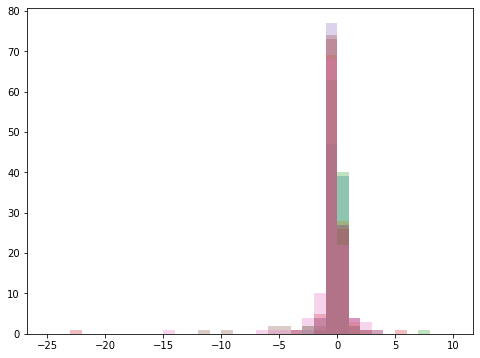

In [105]:
plt.figure(figsize=(8,6))
for iori in np.arange(nori):
#     plt.hist(adp_mag[:,iori], alpha=0.3)
    plt.hist(adp_mag[:,iori], bins=np.linspace(-25,10,36), alpha=0.3)

In [281]:
mag = adp_mag.flatten('F')
ad = dfof_ad.flatten('F')
tg = dfof_tg.flatten('F')
stim = [np.arange(nori)] * adp_mag.shape[0]
stim_flat = np.sort([item for sublist in stim for item in sublist])
stim_flat.shape, mag.shape, ad.shape

((847,), (847,), (847,))

In [282]:
df = pd.DataFrame({'stim':stim_flat, 'mag':mag, 'ad':ad, 'tg':tg})
df

,stim,mag,ad,tg
0,0,NaN,0.004911,0.010702
1,0,-0.270371,0.096553,0.070448
2,0,0.404955,0.043873,0.061639
3,0,0.078625,0.023006,0.024814
4,0,0.071251,0.048574,0.052035
...,...,...,...,...
842,6,-0.303705,0.017647,0.012288
843,6,-0.946363,0.010285,0.000552
844,6,-4.545728,-0.000823,0.002919
845,6,0.509572,0.008689,0.013116


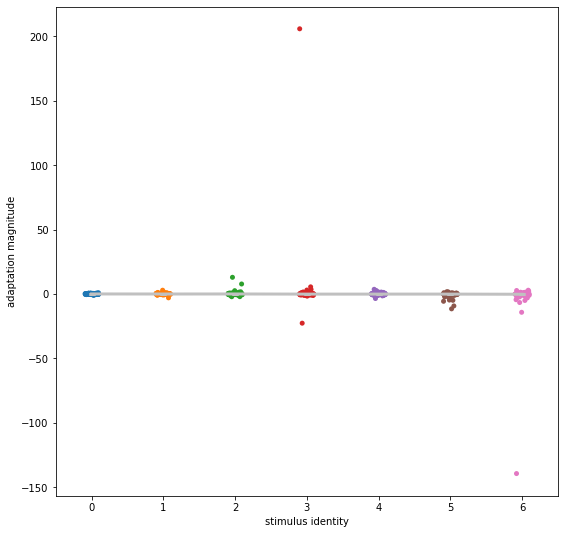

In [316]:
plt.figure(figsize=(9,9))

plt.errorbar(np.arange(nori), mag_median, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="mag", data=df);

# plt.ylim(-5,5);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

In [169]:
mag_mean = df[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_median = df[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_std = df[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_sem = df[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
df[['mag','stim']].groupby(['stim'], sort=False).describe()

mag                                                                 \
      count      mean        std         min       25%       50%       75%   
stim                                                                         
0      87.0 -0.055722   0.333009   -1.237675 -0.296637 -0.069403  0.132607   
1     103.0 -0.097542   0.573734   -3.090850 -0.298679 -0.115285  0.056971   
2     112.0  0.105213   1.533797   -2.221198 -0.364330 -0.068741  0.176492   
3     113.0  1.572952  19.538023  -22.783439 -0.437561 -0.184868  0.166089   
4     116.0 -0.166487   0.747440   -3.618084 -0.423483 -0.192269  0.054999   
5     116.0 -0.541183   1.723481  -11.646174 -0.478584 -0.203371 -0.010074   
6     117.0 -1.753809  12.978342 -139.651267 -0.652298 -0.318741 -0.012836   

                  
             max  
stim              
0       0.883748  
1       2.833710  
2      12.859465  
3     205.983176  
4       3.543835  
5       1.681211  
6       2.819863

### add dfof_ad thresholding

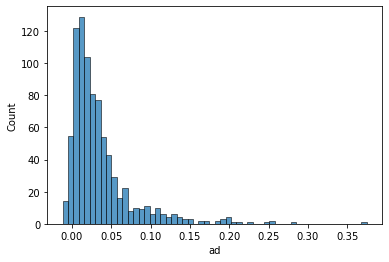

In [204]:
sns.histplot(data=df, x='ad');

In [191]:
sum(df.ad < 0) / len(df) # percent of negative dfof_ad

0.0590318772136954

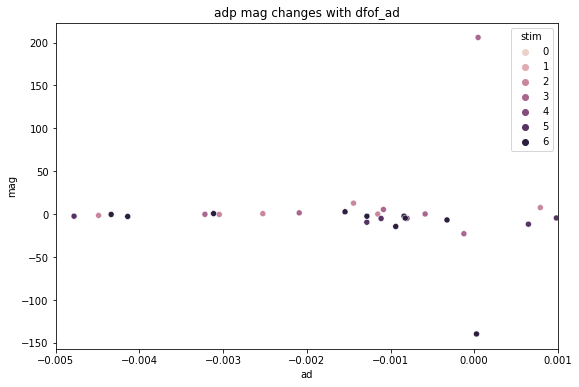

In [180]:
plt.figure(figsize=(9,6))
ax = sns.scatterplot(data=df, x="ad", y="mag", hue="stim")
plt.xlim([-0.005,0.001]);
ax.set(title = 'adp mag changes with dfof_ad');

In [193]:
df2 = df.sort_values(by=['ad'])

def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df2['ad'], df2['mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.xlim([-0.002,0.002])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling mean')
    plt.title('adp mag rolling mean change with dfof_ad of cells')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

In [194]:
df2 = df.sort_values(by=['ad'])

def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df2['ad'], df2['mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.xlim([-0.002,0.002])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling std')
    plt.title('adp mag rolling std change with dfof_ad of cells')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

cell selection: vis_ad only, with dfof_ad thresholding

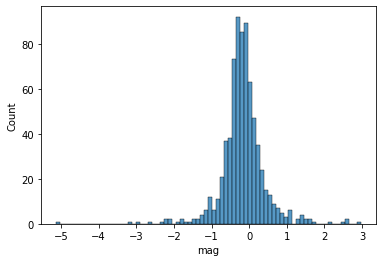

In [283]:
dfof_threshold = 0.002
df_th = df.copy()
df_th.loc[df_th[np.abs(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan
sns.histplot(data=df_th, x='mag');

In [285]:
df_th[['mag','ad','tg','stim']].groupby(['stim'], sort=False).describe()

mag                                                              \
      count      mean       std       min       25%       50%       75%   
stim                                                                      
0      87.0 -0.055722  0.333009 -1.237675 -0.296637 -0.069403  0.132607   
1     101.0 -0.096928  0.400290 -1.088400 -0.292219 -0.115285  0.056290   
2     108.0 -0.090391  0.584746 -2.221198 -0.367597 -0.084761  0.161613   
3     108.0 -0.134984  0.627825 -1.774232 -0.438076 -0.196271  0.081717   
4     113.0 -0.184539  0.561863 -2.140044 -0.423297 -0.192613  0.030113   
5     109.0 -0.164131  0.552767 -2.346489 -0.415025 -0.190284  0.012717   
6     109.0 -0.361829  0.910761 -5.131041 -0.592932 -0.308804 -0.012836   

                   ad            ...                         tg            \
           max  count      mean  ...       75%       max  count      mean   
stim                             ...                                        
0     0.883748  121.0  0.042030  ...  0.045001  0.251187  121.0  0.040626   
1     1.367621  121.0  0.034104  ...  0.046836  0.185454  121.0  0.029591   
2     2.468145  121.0  0.047613  ...  0.053728  0.374842  121.0  0.046022   
3     2.959567  121.0  0.027841  ...  0.032663  0.189126  121.0  0.022785   
4     2.612212  121.0  0.041966  ...  0.052322  0.257215  121.0  0.032933   
5     1.681211  121.0  0.027210  ...  0.032339  0.173376  121.0  0.022095   
6     2.606359  121.0  0.024358  ...  0.030030  0.191323  121.0  0.018860   

                                                                  
           std       min       25%       50%       75%       max  
stim                                                              
0     0.052997 -0.012422  0.011102  0.025786  0.047083  0.334161  
1     0.032131 -0.005394  0.007854  0.019366  0.038624  0.164210  
2     0.063872 -0.023221  0.011427  0.028055  0.049301  0.367123  
3     0.026434 -0.006986  0.006236  0.014414  0.032302  0.181473  
4     0.036089 -0.006134  0.010711  0.024228  0.043397  0.217830  
5     0.026837 -0.008429  0.006920  0.013198  0.029065  0.145712  
6     0.028491 -0.009693  0.002936  0.011041  0.022364  0.149292  

[7 rows x 24 columns]

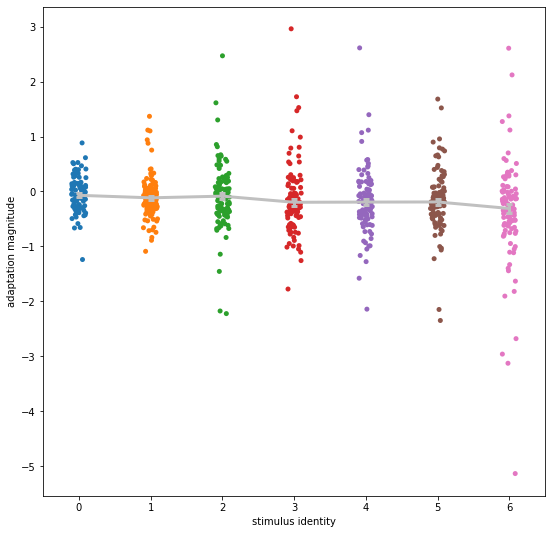

In [218]:
mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()

plt.figure(figsize=(9,9))
plt.errorbar(np.arange(nori), mag_median, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="mag", data=df_th);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

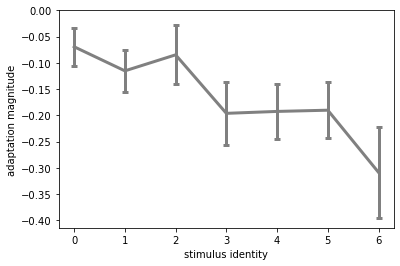

In [267]:
plt.errorbar(np.arange(nori), mag_median, yerr=mag_sem, zorder=100, 
             color='gray', linewidth=3, capsize=3, capthick=3);
plt.gca().set_ylim(top=0);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

### dfof_ad & dfof_tg across stims

In [288]:
df_th.loc[df_th[np.abs(df.ad) < dfof_threshold].index.to_numpy(),['ad','tg','mag']] = np.nan # threshold by dfof_ad
df_th.tail()

,stim,mag,ad,tg
842,6,-0.303705,0.017647,0.012288
843,6,-0.946363,0.010285,0.000552
844,6,NaN,NaN,NaN
845,6,0.509572,0.008689,0.013116
846,6,0.004448,0.014066,0.014128


In [307]:
stim_flat_cp = np.concatenate([df_th.stim, df_th.stim])
dfof_flat = np.concatenate([df_th.ad, df_th.tg])
adtg_flat = [['ad','tg']] * df_th.shape[0]
adtg_flat = np.sort([item for sublist in adtg_flat for item in sublist])
df_cp = pd.DataFrame({'stim':stim_flat_cp, 'dfof': dfof_flat, 'ad_or_tg': adtg_flat})
df_cp

,stim,dfof,ad_or_tg
0,0,0.004911,ad
1,0,0.096553,ad
2,0,0.043873,ad
3,0,0.023006,ad
4,0,0.048574,ad
...,...,...,...
1689,6,0.012288,tg
1690,6,0.000552,tg
1691,6,NaN,tg
1692,6,0.013116,tg


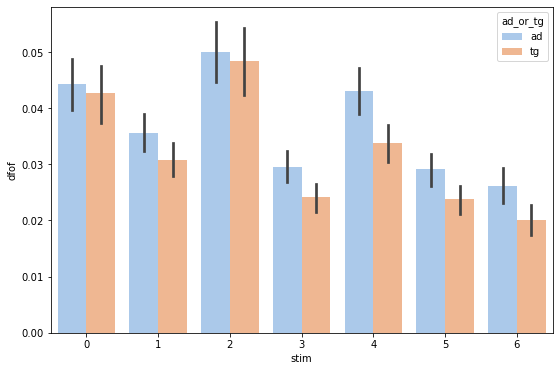

In [314]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x="stim", y="dfof", hue="ad_or_tg", data=df_cp, ci=68, palette="pastel") # mean +- sem

## Trace

In [235]:
trace_mean = np.mean(trace, axis=0)
trace_std = np.std(trace, axis=0)
trace_sem = trace_std / np.sqrt(trace.shape[0])

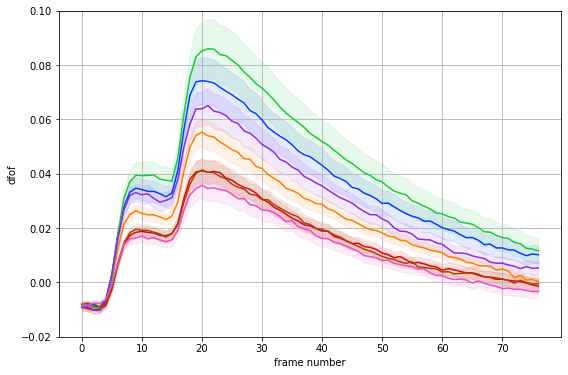

In [317]:
# fig, ax = plt.subplots(figsize=(20,15))
fig, ax = plt.subplots(figsize=(9,6))

for iori in np.arange(nori):
    ax.plot(np.arange(trace.shape[2]), trace_mean[iori,:].flatten(), color=sns.color_palette("bright")[iori])
    ax.fill_between(np.arange(trace.shape[2]), 
                    trace_mean[iori,:].flatten() + trace_sem[iori,:].flatten(), 
                    trace_mean[iori,:].flatten() - trace_sem[iori,:].flatten(),
                    color=sns.color_palette("bright")[iori], alpha=0.1)
plt.grid('minor')
plt.ylim(-0.02,0.10)
plt.xlabel('frame number')
plt.ylabel('dfof')
plt.show()

## Misc
### Adaptation increases variability for natural stim too
for target after adaptation, fano factor is higher than adapter  
cell selection: vis_ad only, with thresholding of dfof_ad

In [270]:
adp_fano_tg = dfof_tg_std / dfof_tg
adp_fano_ad = dfof_ad_std / dfof_ad
adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_tg + adp_fano_ad)

In [274]:
adp_fano_tg = dfof_tg_std / dfof_tg
adp_fano_ad = dfof_ad_std / dfof_ad
adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_tg + adp_fano_ad) # range [-1,1], meaning fano factor de/increase after adp

df_fano = df_th.copy()
df_fano['fano'] = adp_fano.flatten('F')
df_fano.tail()

,stim,mag,ad,fano
842,6,-0.303705,0.017647,0.227742
843,6,-0.946363,0.010285,0.885427
844,6,NaN,-0.000823,-1.808887
845,6,0.509572,0.008689,-0.184105
846,6,0.004448,0.014066,0.071005


In [273]:
df_fano[['fano','stim']].groupby(['stim'], sort=False).describe()

fano                                                               \
      count      mean       std        min       25%       50%       75%   
stim                                                                       
0     121.0  0.052920  0.576917  -4.594001 -0.047361  0.093442  0.209409   
1     121.0  0.135430  5.407791 -26.093405  0.014326  0.089195  0.193997   
2     121.0 -0.158760  2.430507 -26.077591 -0.056197  0.065722  0.194823   
3     121.0 -0.084555  3.564811 -37.400224 -0.003067  0.140460  0.281348   
4     121.0  0.149605  0.823570  -4.510934  0.010311  0.113901  0.250512   
5     121.0 -0.158757  1.653200 -15.050779 -0.021480  0.088770  0.240371   
6     121.0  0.719988  6.736332  -7.174958 -0.007540  0.150818  0.378640   

                 
            max  
stim             
0      1.720485  
1     49.631555  
2      2.801406  
3     10.253987  
4      4.552109  
5      1.686991  
6     72.969290

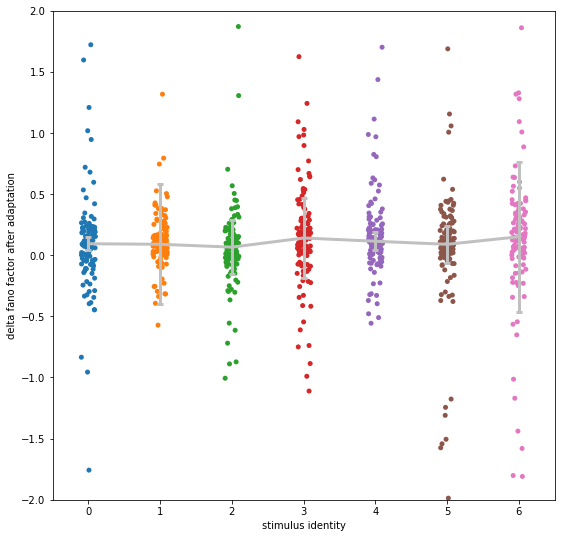

In [278]:
fano_mean = df_fano[['fano','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
fano_median = df_fano[['fano','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
fano_std = df_fano[['fano','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
fano_sem = df_fano[['fano','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()

plt.figure(figsize=(9,9))
plt.errorbar(np.arange(nori), fano_median, yerr=fano_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="fano", data=df_fano);
plt.ylabel('delta fano factor after adaptation');
plt.xlabel('stimulus identity');
plt.ylim(-2,2);